# This notebook completes a phase of characterization of the tactics and investigates the fingerprints
## (Figures 9 and 13 of the paper) 

### Characterization

Import dataset

In [1]:
from tqdm import tqdm
tqdm.pandas()
import pandas as pd 
predicted_corpus = pd.read_parquet(f"../1.Dataset/Inference_with_predictions/logprecis_predictions.parquet")
predicted_corpus.head(2)

,session_id,sequence_words,sequence_predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."


Concatenate `sequence words` and `sequence_predictions`

In [2]:
predicted_corpus["sessions"] = predicted_corpus["sequence_words"].progress_apply(
                                                lambda split_session: " ".join(split_session))
predicted_corpus["predictions"] = predicted_corpus["sequence_predictions"].progress_apply(
                                                lambda split_prediction: " -- ".join(split_prediction))
print(f"Corpus contains {predicted_corpus.shape[0]:,} sessions ({predicted_corpus.sessions.nunique():,} unique)")
print(f"Furthermore, corpus contains {predicted_corpus.predictions.nunique()} unique fingerprints")
predicted_corpus.head(2)

100%|██████████| 233035/233035 [00:01<00:00, 149936.67it/s]


Corpus contains 233,035 sessions (233,035 unique)
Furthermore, corpus contains 1673 unique fingerprints


,session_id,sequence_words,sequence_predictions,sessions,predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


In [3]:
from datetime import datetime
THRESHOLD_UPDATE = "08/11/2019"
server_update_date = datetime.strptime(THRESHOLD_UPDATE, '%d/%m/%Y').date()
server_update_datetime = datetime.strptime(THRESHOLD_UPDATE, '%d/%m/%Y')

print(f"Server update occurred in {server_update_date}")

Server update occurred in 2019-11-08


Load original data

In [4]:
full_corpus = pd.read_csv(f"../1.Dataset/Inference/cyberlab_data.csv")
if "session_id" in full_corpus.columns:
    full_corpus = full_corpus.drop("session_id", axis=1)
full_corpus = full_corpus.reset_index().rename({"index":"session_id"}, axis=1)
full_corpus.head(2)

,session_id,session,sensor,first_timestamp,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,2019-06-04
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,2019-06-04


Join with predictions

In [5]:
joined_corpus = full_corpus[["session_id", "first_timestamp", "sensor", "date"]].merge(predicted_corpus[["session_id", "sessions", "predictions"]], on="session_id")
joined_corpus.head(2)

,session_id,first_timestamp,sensor,date,sessions,predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


Create date attribute

In [6]:
joined_corpus["first_timestamp"] = pd.to_datetime(joined_corpus["first_timestamp"])
joined_corpus["date"] = joined_corpus["first_timestamp"].apply(lambda datetime: datetime.date())
joined_corpus.head(2)

,session_id,first_timestamp,sensor,date,sessions,predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


Plot distribution of intents over time

In [7]:
sessions_date_predictions = joined_corpus[["sessions", "predictions", "date"]].copy()
sessions_date_predictions["splitted_session"] = sessions_date_predictions["sessions"].apply(lambda session: session.split(" "))
sessions_date_predictions["splitted_prediction"] = sessions_date_predictions["predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = sessions_date_predictions[["splitted_session", "splitted_prediction", "date"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

Exploded dataset contains 28150954 rows and 3 columns


,splitted_session,splitted_prediction,date
0,enable,Discovery,2019-06-04
0,;,Discovery,2019-06-04


##### Groupby date

In [8]:
occurrences_x_day = exploded_df.groupby(["date", "splitted_prediction"]).size().reset_index(name = "daily_occurrences")
occurrences_x_day.head(5)

,date,splitted_prediction,daily_occurrences
0,2019-06-04,Defense Evasion,660
1,2019-06-04,Discovery,4123
2,2019-06-04,Execution,1546
3,2019-06-05,Defense Evasion,802
4,2019-06-05,Discovery,6680


Calculate CDF

In [9]:
occurrences_x_day["cumulative_occurrences"] = occurrences_x_day.groupby(['splitted_prediction'])['daily_occurrences'].cumsum()
occurrences_x_day = occurrences_x_day.merge(occurrences_x_day.groupby("splitted_prediction")["daily_occurrences"].sum().reset_index(name = "tot_occurrences"), on = "splitted_prediction")
occurrences_x_day["cdf"] = occurrences_x_day.apply(lambda row: row["cumulative_occurrences"] / row["tot_occurrences"], axis = 1)
occurrences_x_day.head(2)

,date,splitted_prediction,daily_occurrences,cumulative_occurrences,tot_occurrences,cdf
0,2019-06-04,Defense Evasion,660,660,138537,0.004764
1,2019-06-05,Defense Evasion,802,1462,138537,0.010553


Create colors

In [10]:
import seaborn as sns
bars = occurrences_x_day.drop_duplicates("splitted_prediction").sort_values(by = "tot_occurrences", ascending = False)
palette = sns.color_palette("bright", bars.splitted_prediction.nunique())
role2color = {color:prediction for color, prediction in zip(bars.splitted_prediction.unique(), palette)}
hex_role2color = {color:prediction for color, prediction in zip(bars.splitted_prediction.unique(), palette.as_hex())}

Fill missing dates with NaN

In [11]:
def plot_cdfs(cdf, dates):
    cdf = cdf.copy().set_index("date")
    cdf.index = pd.DatetimeIndex(cdf.index)
    cdf = cdf.reindex(dates, method = 'ffill') #Every prediction must be equally indexed: if no improvements that day, put last valid value
    return cdf.asfreq('D')

Plot

In [12]:
dates = occurrences_x_day.date.unique()

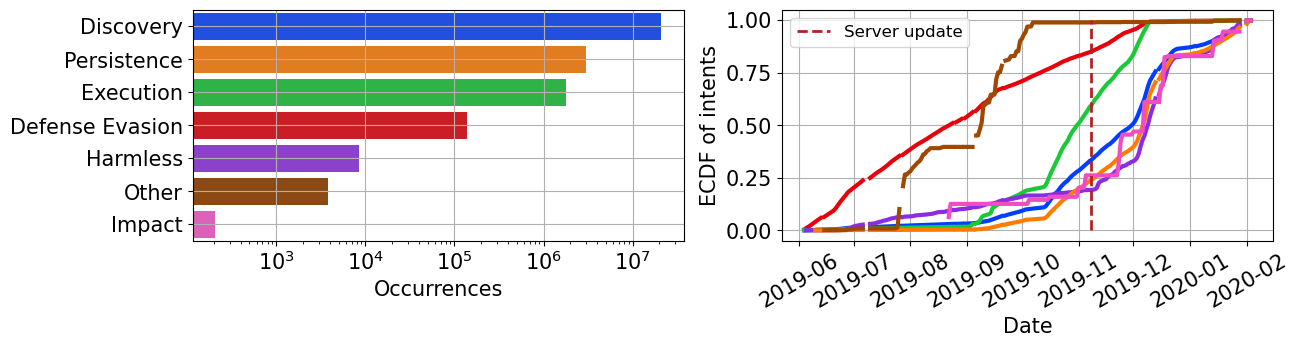

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize =(12, 3))
fontsize = 15
#Axis 1
sns.barplot(data=bars, x="tot_occurrences", y ="splitted_prediction", hue = "splitted_prediction", dodge = False, palette = role2color, ax = axs[0])
axs[0].legend_.remove()
axs[0].set_xlabel('Occurrences', fontsize = fontsize)
axs[0].set_ylabel("")
axs[0].set_xscale("log")
axs[0].xaxis.set_tick_params(labelsize=fontsize)
axs[0].yaxis.set_tick_params(labelsize=fontsize)
axs[0].grid()
#Axis 2

for role in occurrences_x_day.splitted_prediction.unique():
    cdf = occurrences_x_day[occurrences_x_day.splitted_prediction == role][["date", "cdf"]]
    cdf = plot_cdfs(cdf, dates)
    axs[1].plot(cdf.index, cdf.cdf, color = role2color[role], linewidth = 3)
    
#sns.lineplot(data=occurrences_x_day, x="date", y ="cdf", hue = "splitted_prediction", palette = role2color, ax = axs[1], linewidth = 3)
axs[1].vlines(server_update_date, 0, 1, label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs[1].set_xlabel('Date', fontsize = fontsize)
axs[1].set_ylabel('ECDF of intents', fontsize = fontsize)
axs[1].yaxis.set_tick_params(labelsize=fontsize)
axs[1].xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
axs[1].legend(fontsize = fontsize - 3, ncol = 1)
axs[1].grid()
plt.subplots_adjust(left=.1, bottom=None, right=1, top=None, wspace=None, hspace=None)

### Now, select one tactic and plot most frequent words (Figure 9)

In [14]:
tactic2word = joined_corpus.copy()
tactic2word["splitted_session"] = tactic2word["sessions"].apply(lambda session: session.split(" "))
tactic2word["splitted_prediction"] = tactic2word["predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = tactic2word[["splitted_session", "splitted_prediction", "date", "session_id"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

Exploded dataset contains 28150954 rows and 4 columns


,splitted_session,splitted_prediction,date,session_id
0,enable,Discovery,2019-06-04,0
0,;,Discovery,2019-06-04,0


##### Count how many unique tuples ("word", "prediction")

In [15]:
grouped_df = exploded_df.groupby(["splitted_session", "splitted_prediction"]).size().reset_index(name = "occurrences_tuple")
print(f"The dataset contains {grouped_df.shape[0]} unique tuples")
grouped_df.head(2)

The dataset contains 411753 unique tuples


,splitted_session,splitted_prediction,occurrences_tuple
0,206.196.180.220^C,Execution,1
1,^C,Discovery,1


#### Now, focus on 1 intent (e.g., "Persistence")

In [16]:
persistence_df = grouped_df[grouped_df["splitted_prediction"] == "Persistence"].copy()
print(f"Selected {persistence_df.shape[0]} unique tuples (word, 'Persistence')")
persistence_df.head(2)

Selected 325854 unique tuples (word, 'Persistence')


,splitted_session,splitted_prediction,occurrences_tuple
485,"!QAZ2wsx#EDC4rfv""",Persistence,86
486,"!QAZ2wsx#EDC4rfv%TGB""",Persistence,2


##### Filter non-alpha words

In [17]:
import re
persistence_df["is_alpha"] = persistence_df["splitted_session"].apply(lambda word: False if re.search('[a-zA-Z]', word) == None else True)
persistence_df["is_flag"] = persistence_df["splitted_session"].apply(lambda word: "-" in word)

filtered_persistence_df = persistence_df[(persistence_df.is_alpha == True) & (persistence_df.is_flag == False)]
print(f"Selected {filtered_persistence_df.shape[0]} rows")
filtered_persistence_df.head(2)

Selected 324291 rows


,splitted_session,splitted_prediction,occurrences_tuple,is_alpha,is_flag
485,"!QAZ2wsx#EDC4rfv""",Persistence,86,True,False
486,"!QAZ2wsx#EDC4rfv%TGB""",Persistence,2,True,False


#### Figure 9B

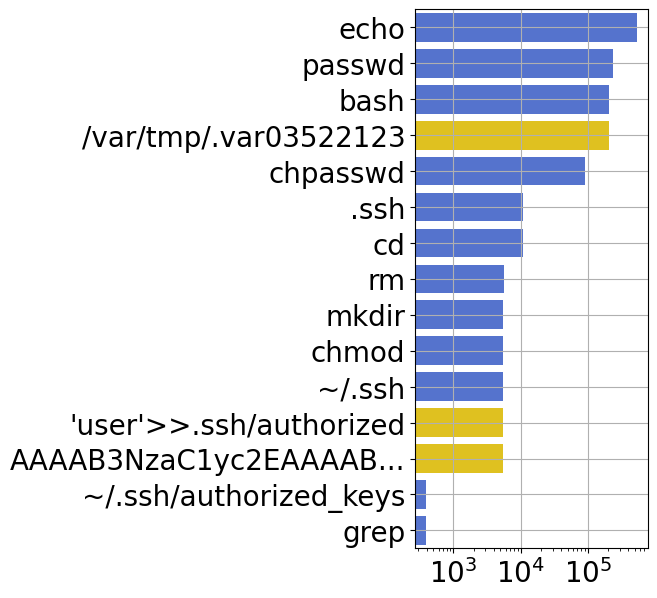

In [18]:
y_ticks = ["echo", "passwd", "bash","/var/tmp/.var03522123", "chpasswd", ".ssh", "cd", "rm", "mkdir", "chmod", "~/.ssh", "'user'>>.ssh/authorized", "AAAAB3NzaC1yc2EAAAAB...", "~/.ssh/authorized_keys","grep"]
top_20 = filtered_persistence_df.sort_values(by = "occurrences_tuple", ascending = False).iloc[:20]
top_20["splitted_session"] = top_20["splitted_session"].apply(lambda word: word[:25])
top_20["is_of_interest"] = top_20["splitted_session"].apply(lambda word: 1 if word in ['mdrfckr">>.ssh/authorized', '"root', "AAAAB3NzaC1yc2EAAAABJQAAA", "/var/tmp/.var03522123"] else 0)
top_20 = top_20[~top_20["splitted_session"].isin(["LC_ALL=C", ">>~/.ssh/authorized_keys", "go=", "AAAAB3NzaC1yc2EAAAADAQABA"])]

fig, axs = plt.subplots(1, figsize =(3, 7))
fontsize = 20
#Axis 1
sns.barplot(data=top_20, x="occurrences_tuple", y="splitted_session", orient = "h", hue = "is_of_interest",dodge = False, ax = axs, palette = {0 : "royalblue", 1 : "gold"}, errwidth = 0)
axs.get_legend().remove()
axs.set_xscale("log")
#axs.set_xlabel('occurrences of (word, "Persistence")', fontsize = fontsize)
axs.set_ylabel("")
axs.set_xlabel("")
#axs.set_xticks([0, 500, 1000])
axs.set_yticks(np.arange(len(y_ticks)))
axs.set_yticklabels(y_ticks)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.grid()

#### Now, focus on 1 intent (e.g., "Execution")

In [19]:
execution_df = grouped_df[grouped_df["splitted_prediction"] == "Execution"].copy()
print(f"Selected {execution_df.shape[0]} unique tuples (word, 'Execution')")
execution_df.head(2)

Selected 5950 unique tuples (word, 'Execution')


,splitted_session,splitted_prediction,occurrences_tuple
0,206.196.180.220^C,Execution,1
3,,Execution,2


##### Filter non-alpha words

In [20]:
import re
execution_df["is_alpha"] = execution_df["splitted_session"].apply(lambda word: False if re.search('[a-zA-Z]', word) == None else True)
execution_df["is_flag"] = execution_df["splitted_session"].apply(lambda word: "-" in word)

filtered_execution_df = execution_df[(execution_df.is_alpha == True) & (execution_df.is_flag == False)]
print(f"Selected {filtered_execution_df.shape[0]} rows")
filtered_execution_df.head(2)

Selected 5355 rows


,splitted_session,splitted_prediction,occurrences_tuple,is_alpha,is_flag
0,206.196.180.220^C,Execution,1,True,False
5,cd,Execution,1,True,False


#### Plot (figure 9a)

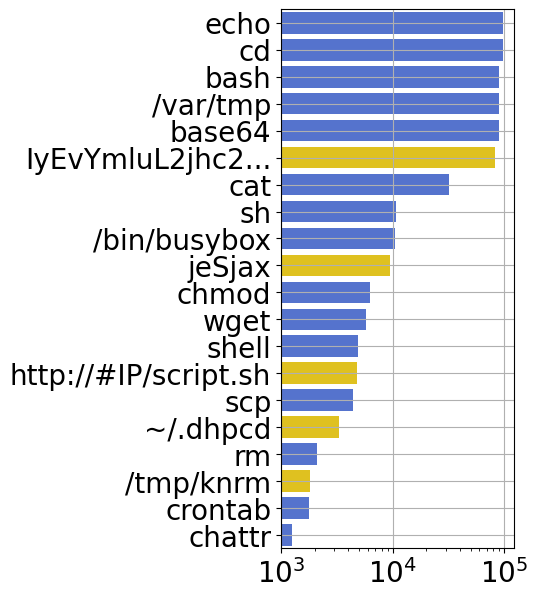

In [21]:
top_30 = filtered_execution_df.sort_values(by = "occurrences_tuple", ascending = False).iloc[:30]
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda word: word[:30])
top_30 = top_30.drop_duplicates("splitted_session")
top_30["is_of_interest"] = top_30["splitted_session"].apply(lambda word: 1 if (word in ["~/.dhpcd", "jeSjax", "http://23.254.230.38/p3n1s.sh", "/tmp/knrm"]) or ("IyEvY" in word) else 0)
#top_30 = top_30[~top_30["splitted_session"].str.contains("IyEvY")]
top_30 = top_30[~top_30["splitted_session"].isin(["15s", "/tmp", "/var/tmp/.systemcache436621", "LC_ALL=C", "/tmp/r", "/home/admin/.dhpcd", "sleep", "/tmp/jeSjax", "$SHELL"])]
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda el: "IyEvYmluL2jhc2..." if ("IyEvY" in el) else el)
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda el: "http://#IP/script.sh" if ("p3n1s" in el) else el)

fig, axs = plt.subplots(1, figsize =(3, 7))
fontsize = 20
#Axis 1
sns.barplot(data=top_30, x="occurrences_tuple", y="splitted_session", orient = "h", hue = "is_of_interest", dodge = False, ax = axs, palette = {0 : "royalblue", 1 : "gold"})
axs.get_legend().remove()
axs.set_xscale("log")
axs.set_xlabel('')
axs.set_ylabel("")
axs.set_xticks([1000, 10000, 100000])
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.grid()

## Now, figure equivalent to figure 13 paper

### Investigate one of the following (i.e., dhpcd)
#### Select only rows that contain the chosen word

In [22]:
from datetime import datetime
print(f"Before filtering, we had {joined_corpus.shape[0]} sessions")
upper_date = datetime.strptime("01/01/2020", '%d/%m/%Y').date()

corpus_of_chosen_word = joined_corpus[(joined_corpus.sessions.str.contains("~/.dhpcd")) & (joined_corpus.date < upper_date)].copy()
print(f"After filtering, we selected {corpus_of_chosen_word.shape[0]} sessions")

Before filtering, we had 233035 sessions
After filtering, we selected 664 sessions


For each fingerprint, get first date in which the fingerprint appeared

In [23]:
corpus_of_chosen_word.sort_values(by = "first_timestamp", inplace = True)
first_appearance_chosen_word = corpus_of_chosen_word.groupby("predictions")["date"].agg("first").reset_index()
print(f"There are {first_appearance_chosen_word.shape[0]} unique sequences of predictions associated")
first_appearance_chosen_word.sort_values(by = "date").head(2)

There are 182 unique sequences of predictions associated


,predictions,date
137,Execution -- Execution -- Execution -- Executi...,2019-09-18
136,Execution -- Execution -- Execution -- Executi...,2019-09-19


Also take into account how many sessions were associated to each sequence

In [24]:
sessions_per_seq = corpus_of_chosen_word.groupby("predictions")["sessions"].count().reset_index(name = "associated_sessions")
birth_and_occurrences = first_appearance_chosen_word.merge(sessions_per_seq, on = "predictions")
print("Displaying examples in the order of date of birth:")
birth_and_occurrences.sort_values(by = "date").head(5)

Displaying examples in the order of date of birth:


,predictions,date,associated_sessions
137,Execution -- Execution -- Execution -- Executi...,2019-09-18,2
136,Execution -- Execution -- Execution -- Executi...,2019-09-19,3
129,Execution -- Execution -- Execution -- Executi...,2019-09-20,4
4,Discovery -- Discovery -- Discovery -- Discove...,2019-09-20,4
128,Execution -- Execution -- Execution -- Executi...,2019-09-23,2


#### We will compare prototypes
##### Remember that within the same family we work on "fixed size" (each family of prediction has the same number of words)

In [25]:
from tqdm import tqdm
families_attacks = corpus_of_chosen_word.predictions.unique() # Obtain set of "families"
df_prototypes = []
for family in tqdm(families_attacks):
    # Select the corresponding sessions
    attacking_sessions = corpus_of_chosen_word[corpus_of_chosen_word.predictions == family][["sessions"]] 
    
    splitted_sessions = attacking_sessions["sessions"].str.split(' ', expand=True)
    assert not splitted_sessions.isnull().values.any(), "Error, NaN in the dataset"
    # Count the number of unique elements per column (each column corresponds to a word)
    prototype = splitted_sessions.nunique().to_frame().T.values
    associated_sessions = birth_and_occurrences[birth_and_occurrences.predictions == family]["associated_sessions"].iloc[0]
    prototype = np.divide(prototype, associated_sessions / 100) 

    # Save how many variable elements there are per family
    varying_elements = len(prototype[(prototype != 1)])
    percentage_varying_elements = varying_elements / prototype.shape[1] * 100
    # Also save the number of associated sessions per family
    associated_sessions = attacking_sessions.shape[0]
    df_prototypes.append([family, associated_sessions, percentage_varying_elements, prototype])

df_prototypes = pd.DataFrame(df_prototypes, columns = ["predictions", "associated_sessions", "percentage_varying_elements", "prototype"])
df_prototypes.head(2)

100%|██████████| 182/182 [00:04<00:00, 37.84it/s]


,predictions,associated_sessions,percentage_varying_elements,prototype
0,Execution -- Execution -- Execution -- Executi...,2,100.0,"[[50.0, 50.0, 100.0, 50.0, 50.0, 100.0, 50.0, ..."
1,Execution -- Execution -- Execution -- Executi...,3,100.0,"[[33.333333333333336, 33.333333333333336, 100...."


Isolate fingerprints with most associated sessions containing dhpcd 

In [26]:
dates_of_interest = birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).iloc[:10].date.values
upper_date_threshold = np.max(dates_of_interest)
lower_date_threshold = np.min(dates_of_interest)
upper_date_threshold, lower_date_threshold

(datetime.date(2019, 10, 17), datetime.date(2019, 10, 7))

In [27]:
session_threshold = birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).iloc[:10].associated_sessions.iloc[-1]
session_threshold

13

In [28]:
top_birth_and_occurrences = birth_and_occurrences[(birth_and_occurrences.date >= lower_date_threshold) & \
                                                (birth_and_occurrences.date <= upper_date_threshold) & \
                                                (birth_and_occurrences.associated_sessions >= session_threshold)].copy()
print(f"Selected top {top_birth_and_occurrences.shape[0]} sequences")
top_birth_and_occurrences.head(2)

Selected top 11 sequences


,predictions,date,associated_sessions
12,Discovery -- Discovery -- Discovery -- Discove...,2019-10-12,14
22,Discovery -- Discovery -- Discovery -- Discove...,2019-10-10,13


In [29]:
first_seq = top_birth_and_occurrences.iloc[8].predictions
second_seq = top_birth_and_occurrences.iloc[3].predictions
third_seq = top_birth_and_occurrences.iloc[9].predictions
fourth_seq = top_birth_and_occurrences.iloc[6].predictions

selected_prototypes = df_prototypes[df_prototypes.predictions.isin([first_seq, second_seq, third_seq, fourth_seq])]
selected_prototypes.head(2)

,predictions,associated_sessions,percentage_varying_elements,prototype
31,Discovery -- Discovery -- Discovery -- Discove...,51,100.0,"[[1.9607843137254901, 1.9607843137254901, 1.96..."
33,Execution -- Execution -- Execution -- Executi...,104,100.0,"[[0.9615384615384615, 0.9615384615384615, 100...."


#### Idea here is that, since working withing the same family, we have guarantees that all sessions associated to that family will have the same number of words
##### If that is the case, we can then visualize which are the n-bit changing

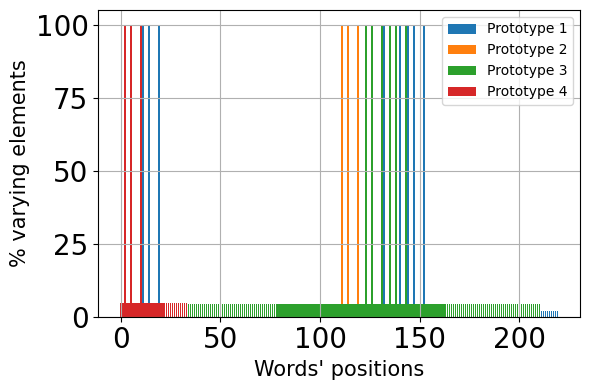

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize=(6,4))
fontsize = 20
random_words = []
for i in range(selected_prototypes.shape[0]):
    to_plot = selected_prototypes.iloc[i].prototype[0]
    axs.bar(np.arange(to_plot.shape[0]), to_plot, label = f"Prototype {i + 1}")
    index_random_word = [it for it, el in enumerate(to_plot) if el>5]
    random_words.append(index_random_word)

axs.set_xlabel("Words' positions", fontsize = fontsize - 5)
axs.set_ylabel('% varying elements', fontsize = fontsize - 5)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.legend()
axs.grid()
plt.tight_layout()
plt.show()

##### Prototypes say that we could basically pick any sessions from the two sequences (only random words changing)

In [31]:
example_first = corpus_of_chosen_word[corpus_of_chosen_word.predictions == first_seq].sessions.iloc[0]
example_second = corpus_of_chosen_word[corpus_of_chosen_word.predictions == second_seq].sessions.iloc[0]
example_third = corpus_of_chosen_word[corpus_of_chosen_word.predictions == third_seq].sessions.iloc[0]
example_fourth= corpus_of_chosen_word[corpus_of_chosen_word.predictions == fourth_seq].sessions.iloc[0]

print(f"\nFirst example:\n")
for word, prediction in zip(first_seq.split(" -- "), example_first.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")
print(f"\nSecond example:\n")
for word, prediction in zip(second_seq.split(" -- "), example_second.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")
print(f"\nThird example:\n")
for word, prediction in zip(third_seq.split(" -- "), example_third.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")
print(f"\nFourth example:\n")
for word, prediction in zip(fourth_seq.split(" -- "), example_fourth.split(" ")):
    print(f"{word} - {prediction}", end = " -- ")


First example:

Execution - scp -- Execution - -t -- Execution - ~/kj22a7yyjfhlaqsf7iifwm7xiu -- Execution - ; -- Execution - LC_ALL=C -- Execution - ~/kj22a7yyjfhlaqsf7iifwm7xiu -- Execution - ; -- Defense Evasion - LC_ALL=C -- Defense Evasion - rm -- Defense Evasion - -f -- Defense Evasion - ~/kj22a7yyjfhlaqsf7iifwm7xiu -- Defense Evasion - ; -- Execution - LC_ALL=C -- Execution - chattr -- Execution - -i -- Execution - -a -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - rm -- Execution - -f -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - rmdir -- Execution - ~/.dhpcd -- Execution - ; -- Execution - scp -- Execution - -t -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - ~/.dhpcd -- Execution - ; -- Execution - LC_ALL=C -- Execution - echo -- Execution - ~ -- Execution - ; -- Discovery - LC_ALL=C -- Discovery - chattr -- Discovery - -i -- Discovery - -a -- Discovery - /etc/shadow -- Discovery

In [32]:
examples = [example_first, example_second, example_third, example_fourth]
for it, random_words_example in enumerate(random_words):
    print(f"Random words for sequence {it + 1}:")
    for it_2 in random_words_example:
        print(f"Word at index {it_2}: {examples[it].split(' ')[it_2]}")
    print()

Random words for sequence 1:
Word at index 11: ;
Word at index 14: -i
Word at index 19: rm
Word at index 132: ;
Word at index 135: /tmp/knrm
Word at index 140: ;
Word at index 144: LC_ALL=C
Word at index 147: ;
Word at index 152: $SHELL

Random words for sequence 2:
Word at index 2: /etc/rc.local
Word at index 5: LC_ALL=C
Word at index 10: -t
Word at index 111: grep
Word at index 114: ~/.ssh/authorized_keys
Word at index 119: AAAAB3NzaC1yc2EAAAADAQABAAABAQDTiGm9b44ZjkQoMkcGuVsC8SGW7a9aFODS6nb64WnMwBwKPja7k56LyBBdVRm+MeKecx6Q/qLn5J+ggJ6um/LoCjKJLrX2dFOjGdyR4ZjnVBwibgr8PLrPoo7bUkaR3DMjfhcmoRlFrj51aN6g0TYHejCmug3TRpg37djYKqJ539iGNcmj021ZlzDBrjfIxUY849O72GsMuytk8n3K6XFxHj8gHyOsB7NgyvE39x9/SoGq2gkQS6TFun6dhmsr+ORokfS2265RwbdEOfnwL2LnQNuhiePlOUHRqzpc0K2pu9TGo1vNRIGSymCatMUNgnNX3tfcuMP5e8f1xDVh7fx3
Word at index 123: netstat
Word at index 126: LC_ALL=C
Word at index 131: -t

Random words for sequence 3:
Word at index 2: ~/r3ilc1yme24l9qbwps05tnq4ab
Word at index 5: ~/r3ilc1yme24l9qbwps05tnq4a

#### Another visualization (not in the paper)

In [33]:
import math
new_selected_prototypes = selected_prototypes.copy()
new_selected_prototypes["prototype"] = new_selected_prototypes["prototype"].apply(lambda el: el[0])
new_selected_prototypes["len_prototype"] = new_selected_prototypes["prototype"].apply(lambda el: len(el))
max_len = new_selected_prototypes["len_prototype"].max()
def pad_prototypes(row):
    len_prototype = row.len_prototype
    padded_prototype = [el for el in row.prototype]
    for it in range(max_len - len_prototype):
        padded_prototype.append(math.nan)
    return np.array(padded_prototype)
new_selected_prototypes["padded_prototype"] = new_selected_prototypes.apply(lambda row: pad_prototypes(row), axis = 1)
new_selected_prototypes

,predictions,associated_sessions,percentage_varying_elements,prototype,len_prototype,padded_prototype
31,Discovery -- Discovery -- Discovery -- Discove...,51,100.0,"[1.9607843137254901, 1.9607843137254901, 1.960...",220,"[1.9607843137254901, 1.9607843137254901, 1.960..."
33,Execution -- Execution -- Execution -- Executi...,104,100.0,"[0.9615384615384615, 0.9615384615384615, 100.0...",199,"[0.9615384615384615, 0.9615384615384615, 100.0..."
36,Execution -- Execution -- Execution -- Executi...,23,100.0,"[4.3478260869565215, 4.3478260869565215, 100.0...",211,"[4.3478260869565215, 4.3478260869565215, 100.0..."
53,Execution -- Execution -- Execution -- Executi...,22,100.0,"[4.545454545454546, 4.545454545454546, 100.0, ...",34,"[4.545454545454546, 4.545454545454546, 100.0, ..."


In [34]:
top_birth_and_occurrences["label"] = top_birth_and_occurrences.apply(lambda row: f"Birth: {row.date.strftime('%b. %d, %Y').rjust(10)} - Associated sessions: {str(row.associated_sessions).rjust(3)}", axis = 1)
top_birth_and_occurrences.head(2)

,predictions,date,associated_sessions,label
12,Discovery -- Discovery -- Discovery -- Discove...,2019-10-12,14,"Birth: Oct. 12, 2019 - Associated sessions: 14"
22,Discovery -- Discovery -- Discovery -- Discove...,2019-10-10,13,"Birth: Oct. 10, 2019 - Associated sessions: 13"


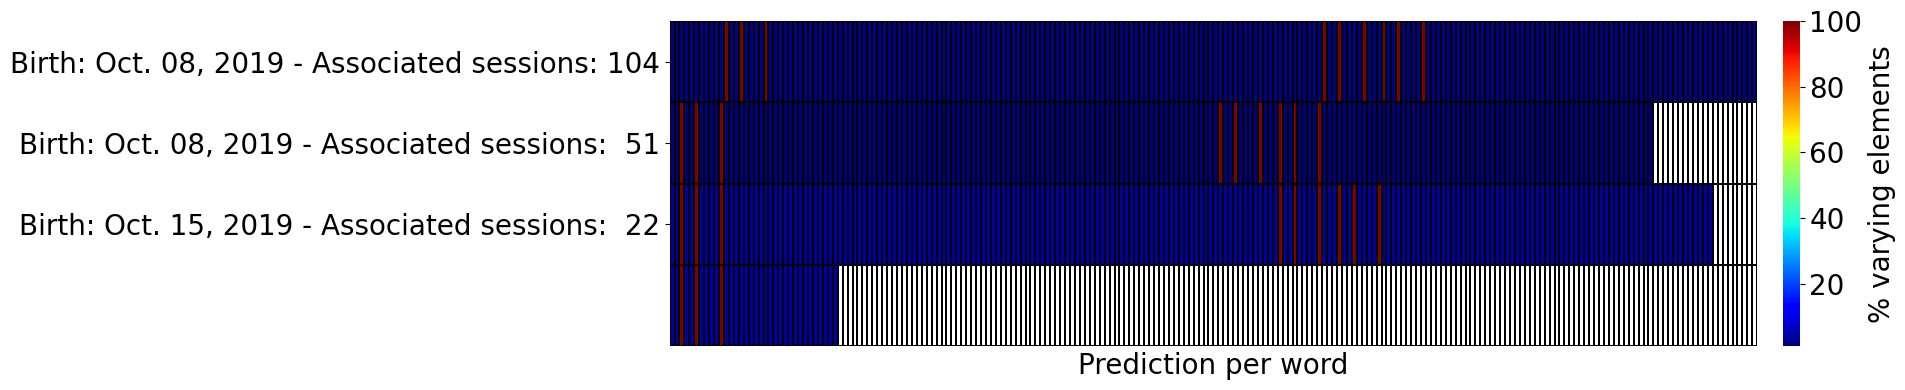

In [35]:
fig, axs = plt.subplots(figsize =(20, 4))
to_visualize = [8, 3, 6]
fontsize = 20
padded_prototype = np.array(list(new_selected_prototypes["padded_prototype"].values))
sns.heatmap(padded_prototype, cmap = "jet", linewidth = 0.003, cbar = True, linecolor = "black", yticklabels=False, 
            xticklabels=False, ax = axs, cbar_kws={"pad": 0.02})
cbar = axs.collections[0].colorbar
cbar.ax.set_ylabel("% varying elements", fontsize = fontsize)
cbar.ax.tick_params(labelsize=fontsize)
axs.set_yticks(np.arange(.5, len(to_visualize) +.5))
axs.set_yticklabels(top_birth_and_occurrences.iloc[to_visualize].label.values, fontsize = fontsize)
axs.set_yticklabels(top_birth_and_occurrences.iloc[to_visualize].label.values, fontsize = fontsize)
axs.set_xlabel("Prediction per word", fontsize = fontsize )
plt.tight_layout()